In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import torchvision
from torchvision import datasets, transforms


class DummyGenerator():
    def __init__(self, hps=None, img_shape=(64,64)):
        self.img_height = img_shape[0]
        self.img_width = img_shape[1]

    
    # Feel free to improve...
        
    def generate_rectangles(self, set_size=1000):
        
        X = torch.ones(size=(set_size, 3, self.img_height, self.img_width))
        Y = torch.ones(size=(set_size, 3, self.img_height, self.img_width))
        
        vertices = np.array([np.random.choice(range(0, self.img_width // 2)), 
                               np.random.choice(range(self.img_width // 2, self.img_width))])
        
        coords_x = np.concatenate([np.arange(0, np.min(vertices - 2)), np.arange(np.max(vertices + 2), self.img_width)])
        coords_y = np.concatenate([np.arange(0, np.min(vertices - 2)), np.arange(np.max(vertices + 2), self.img_height)])
        
        Y[:, :, coords_x, :] = 0
        Y[:, :, :, coords_y] = 0
        
        lines_x = np.concatenate([coords_x, np.arange(np.min(vertices), np.max(vertices))])
        lines_y = np.concatenate([coords_y, np.arange(np.min(vertices), np.max(vertices))])
        
        h = torch.ones(size=(set_size, 3, self.img_height, self.img_width))
        v = torch.ones(size=(set_size, 3, self.img_height, self.img_width))
        
        h[:, :, lines_x, :] = 0
        v[:, :, :, lines_y] = 0
        
        X = h + v
        
        X[:, :, coords_x, :] = 0
        X[:, :, :, coords_y] = 0
        
        return X, Y
     
    

In [3]:
from torch.utils.data import Dataset, TensorDataset
import torchvision.transforms.functional as TF


class CustomTensorDataset(Dataset):
    """
    TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        
        
    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]
        
        x, y = self.transform(x, y)

        return x, y
    
    
    def transform(self, x, y):
        
        to_image = transforms.ToPILImage()
        to_tensor = transforms.ToTensor()
        
        x = to_image(x)
        y = to_image(y)
        
        angle = np.random.randint(-90, 90)
        translate = [np.random.randint(-20, 20), np.random.randint(-20, 20)]
        scale = np.random.uniform(1, 1.25)
        shear = np.random.randint(-30, 30)
        hflip = np.random.random() < 0.5
        
        x = TF.affine(x, angle, translate, scale, shear)
        y = TF.affine(y, angle, translate, scale, shear)
        
        if hflip:
            x = TF.hflip(x)
            y = TF.hflip(y)
        
        x = to_tensor(x)
        y = to_tensor(y)
        
        return x, y
        
        
    def __len__(self):
        return self.tensors[0].size(0)
    
    
def imshow(img, title=''):
    """Plot the image batch.
    """
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.numpy(), (1, 2, 0)), cmap='gray')
    plt.show()

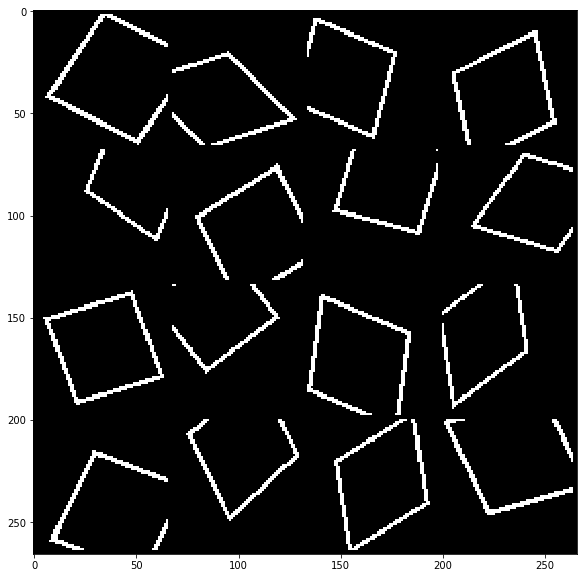

In [5]:
import matplotlib.pyplot as plt

generator = DummyGenerator()
X, Y = generator.generate_rectangles()

dataset = CustomTensorDataset(tensors=(X, Y))
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

for i, data in enumerate(loader):
    x, y = data  
    imshow(torchvision.utils.make_grid(x, 4))
    break


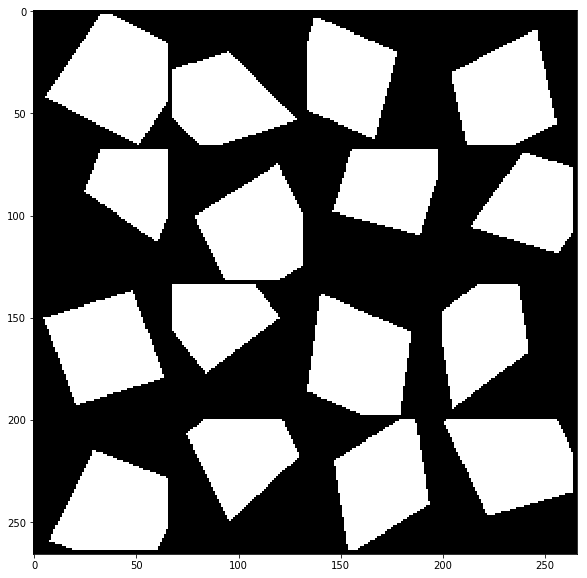

In [6]:
imshow(torchvision.utils.make_grid(y, 4))